# Austin Granular Model

## Input data

### 1. Travel between ZCTAs

Required columns and data formats

|column header|format|description|
|:---|:---|:---|
|source|`str`|source or origin ZCTA|
|destination|`str`|destination ZCTA|
|age|`str`|name of age bin|
|n|`float`|estimated number of travelers between source and destination ZCTA|
|date|`str`|YYYY-MM-DD that can be parsed to `datetime.datetime` object|

**Note** When source and destination are the same, the value in column "n" represents the population that does not leave the ZCTA. These rows must be present.

These data are used to calculate contact probabilities, so while the underlying census reflected in this dataset will change over time, we can still initialize model compartments with the census data that corresponds to the epidemic start date.

In [1]:
import pandas as pd

In [2]:
example_travel = pd.read_csv(
    '/Users/kpierce/epimodels/notebooks/AustinGranularModel/DataIntegration/final_aisd_2018_2019_travel_backup.csv'
)

/Users/kpierce/epimodels/epi-venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
example_travel = example_travel.drop(
    columns=['Unnamed: 0', 'year', 'school_closed']
).rename(
    columns={'source_zip': 'source', 'dest_zip': 'destination', 'n_travel': 'n', 'revised_age_group': 'age'}
)
example_travel['source'] = example_travel['source'].astype(str)
example_travel['destination'] = example_travel['destination'].astype(str)

In [4]:
example_travel_first_month = example_travel[example_travel['date'] < '2018-04-01']

In [5]:
example_travel.to_csv('/Users/kpierce/epimodels/notebooks/AustinGranularModel/AGM_Demo_Final_Data/final_aisd_2018_2019_travel.csv')

In [6]:
example_travel_first_month.to_csv('/Users/kpierce/epimodels/notebooks/AustinGranularModel/AGM_Demo_Final_Data/example_travel.csv')


### 2. Initial census population

Required columns and data formats

**Note** The population total by source in travel data frame described above must match the population total by source in this data frame.

In [7]:
census = pd.read_csv('/Users/kpierce/epimodels/notebooks/AustinGranularModel/DataIntegration/zcta_age_groups_for_initalizing_model_compartments_2018_2019.csv')


In [8]:
census = census[census['year'] == 2018].rename(
    columns={'revised_age_group': 'age_bin', 'risk_population': 'group_pop'}
).drop(columns=['year', 'Unnamed: 0'])

In [9]:
census.to_csv('/Users/kpierce/epimodels/notebooks/AustinGranularModel/AGM_Demo_Final_Data/initial_model_state.csv')

### 3. Age structured per capita contact rates

Required columns and data formats

**Note** The age groups in this dataset must match the age groups in the travel and initial census population dataframes.

In [11]:
import xarray as xr

In [12]:
contacts_da = xr.open_dataarray(
    '/Users/kpierce/epimodels/notebooks/AustinGranularModel/BaselineContacts/usa_baseline_contacts_seven_age_groups_avg2018_2019.nc/',
    engine='netcdf4'
)

In [13]:
contacts_df = contacts_da.to_dataframe().reset_index()

In [14]:
contacts_df = contacts_df.rename(columns={'age0': 'age1', 'age1': 'age2'})

In [15]:
contacts_df.to_csv('/Users/kpierce/epimodels/notebooks/AustinGranularModel/BaselineContacts/usa_baseline_contacts_seven_age_groups_avg2018_2019.csv')
    

### 4. Add scaling factor to contact rates

Inside episimlab, the force of infection is calculated as `beta` * `polymod-based baseline per capita contact rate by age group` * `travel based probability of contact by age group and ZCTA`.

In [51]:
mi = pd.read_csv(
    '/Users/kpierce/epimodels/notebooks/AustinGranularModel/MobilityIndex/mobilityRatioWith2018.csv',
    dtype={'Zip': str}
)

In [52]:
mi.head()

,Date,Zip,MobRatio,MobRatioNormal,MobRatioNormScaled
0,2020/01/01,78617,9.060748,0.104398,0.470866
1,2020/01/02,78617,12.613108,0.145331,0.525758
2,2020/01/03,78617,12.544790,0.144544,0.524807
3,2020/01/04,78617,14.108844,0.162566,0.545770
4,2020/01/05,78617,12.632877,0.145559,0.526033


In [53]:
mi.describe()

,MobRatio,MobRatioNormal,MobRatioNormScaled
count,6828.000000,6828.000000,6828.000000
mean,2.106566,0.024267,0.252083
std,3.197009,0.036838,0.100079
min,0.000588,0.000000,0.000000
25%,0.464561,0.005346,0.174857
50%,1.200094,0.013822,0.239986
75%,2.925690,0.033705,0.323022
max,86.785420,1.000000,1.000000


In [54]:
mi = mi[['Date', 'Zip', 'MobRatioNormScaled']].rename(columns={'Date': 'date', 'Zip': 'vertex', 'MobRatioNormScaled': 'kappa'})

In [55]:
type(mi['date'].iloc[0])

str

In [84]:
from dateutil.relativedelta import relativedelta
from datetime import datetime

mi['datetime'] = [datetime.strptime(i, '%Y/%m/%d') for i in mi['date']]

offset_dates = []
for i in mi['datetime']:
    try:
        offset_dates.append(datetime(2018, i.month, i.day))
    except ValueError:
        offset_dates.append('')
mi['datetime'] = offset_dates
mi = mi[['vertex', 'kappa', 'datetime']].rename(columns={'datetime': 'date'}).dropna()

In [85]:
mi.head()

,vertex,kappa,date
0,78617,0.470866,2018-01-01
1,78617,0.525758,2018-01-02
2,78617,0.524807,2018-01-03
3,78617,0.545770,2018-01-04
4,78617,0.526033,2018-01-05


In [86]:
mi.to_csv('/Users/kpierce/epimodels/notebooks/AustinGranularModel/MobilityIndex/kappa2018.csv')

## Model

We use model `SEPIRSevenAgesNoVis`, which integrates the new seven-age group contact structure with the backbone SEIR model is defined in [`PartitionV1`](https://github.com/UT-Covid/episimlab/blob/granular-model/episimlab/models/partition_v1.py); this model structure was used extensively by the UT COVID-19 Modeling Consortium in 2020 and is described in numerous white papers and reports. The first peer-reviewed publication describing this model structure is here: https://www.nature.com/articles/s41467-021-23989-x

Install development version of `episimlab`:
- navigate to local directory with `episimlab`
- run `pip3 install .`

In [1]:
#from epimodels.sepiarv_seven_ages_omicron import SEPIRSevenAgesNoVis
#from epimodels.sepiar_seven_ages import SEPIRSevenAgesNoVis
#from epimodels.sepiarv_seven_ages import SEPIRSevenAgesNoVis
from epimodels.sepiar_with_kappa import SEPIRSevenAgesNoVis

In [2]:
import multiprocessing as mp
import numpy as np
import pandas as pd

In [3]:
def entropy_generator(n_sims):

    seeds = np.random.SeedSequence(entropy=(8888))
    entropy_list = seeds.generate_state(n_sims)

    return entropy_list

def demo_model(seed_entropy):

    model = SEPIRSevenAgesNoVis()

    # set model defaults
    model.RUNNER_DEFAULTS['input_vars']['travel_pat_fp'] = '/Users/kpierce/epimodels/notebooks/AustinGranularModel/AGM_Demo_Final_Data/example_travel.csv'
    model.RUNNER_DEFAULTS['input_vars']['contacts_fp'] = '/Users/kpierce/epimodels/notebooks/AustinGranularModel/BaselineContacts/usa_baseline_contacts_seven_age_groups_avg2018_2019.csv'
    model.RUNNER_DEFAULTS['input_vars']['census_fp'] = '/Users/kpierce/epimodels/notebooks/AustinGranularModel/AGM_Demo_Final_Data/initial_model_state.csv'
    model.RUNNER_DEFAULTS['input_vars']['kappa_fp'] = '/Users/kpierce/epimodels/notebooks/AustinGranularModel/MobilityIndex/kappa2018.csv'
    model.RUNNER_DEFAULTS['clocks']['step'] = pd.DatetimeIndex(
        pd.date_range(
            start='2018-01-01',
            end='2018-03-31'
        )
    )
    
    # seed entropy is passed to each run of the model
    input_vars = {'setup_seed__seed_entropy': seed_entropy}
    sim_result = model.run(input_vars=input_vars)

    return sim_result

In [4]:
seeds = entropy_generator(10)

In [5]:
demo_result = [demo_model(i) for i in seeds]

INFO:root:No path to config (`config_fp`) was specified. Using model defaults.
INFO:root:The date in Partition.get_travel_df is ['2018-01-01T00:00:00.000000000']
INFO:root:Initializing epidemic in vertex ['78738'], age group ['11-13'], risk group ['high']
INFO:root:The date in Partition.get_travel_df is ['2018-01-01T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-01T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-01T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-01T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-01T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-02T00:00:00.000000000']
ERROR:root:2.4% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-02T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-03T00:00:00.000000000']
ERROR:root:83.1% values in t

ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-08T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-09T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-09T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-10T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-10T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-11T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-11T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-12T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-12T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-13T00:00:00.000000000']
ERROR:root:

ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-22T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-23T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-23T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-24T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-24T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-25T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-25T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-26T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-26T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-27T00:00:00.000000000']
ERROR:root:

INFO:root:The date in Partition.get_travel_df is ['2018-01-31T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-01T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-01T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-02T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-02T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-03T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-03T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-04T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-04T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-05T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:T

INFO:root:The date in Partition.get_travel_df is ['2018-03-14T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-14T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-15T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-15T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-16T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-16T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-17T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-17T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-18T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-18T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-19T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.ge

INFO:root:The date in Partition.get_travel_df is ['2018-01-24T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-24T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-25T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-25T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-26T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-26T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-27T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-27T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-28T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-28T00:00:00.000000000']
INFO:root:T

INFO:root:The date in Partition.get_travel_df is ['2018-03-05T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-06T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-06T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-07T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-07T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-08T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-08T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-09T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-09T00:00:00.000000000']
INFO:root:The date in Partition.get_trave

INFO:root:The date in Partition.get_travel_df is ['2018-01-16T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-16T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-17T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-17T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-18T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-18T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-19T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-19T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-20T00:00:00.000000000']
INFO:root:The date in Partition.get_trave

INFO:root:The date in Partition.get_travel_df is ['2018-02-25T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-26T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-26T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-27T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-27T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-28T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-28T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-01T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-01T00:00:00.000000000']
INFO:root:The date in Partition.get_trave

INFO:root:The date in Partition.get_travel_df is ['2018-01-07T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-08T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-08T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-09T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-09T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-10T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-10T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-11T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-11T00:00:00.000000000']
INFO:root:The date in Partition.get_trave

INFO:root:The date in Partition.get_travel_df is ['2018-02-17T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-17T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-18T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-18T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-19T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-19T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-20T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-20T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-21T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-21T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-22T00

INFO:root:The date in Partition.get_travel_df is ['2018-01-01T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-01T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-01T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-01T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-01T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-02T00:00:00.000000000']
ERROR:root:2.4% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-02T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-03T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-03T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-04T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:Th

ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-09T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-10T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-10T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-11T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-11T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-12T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-12T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-13T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-13T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-14T00:00:00.000000000']
ERROR:root:

ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-23T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-24T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-24T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-25T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-25T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-26T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-26T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-27T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-27T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-28T00:00:00.000000000']
ERROR:root:

INFO:root:The date in Partition.get_travel_df is ['2018-02-01T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-02T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-02T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-03T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-03T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-04T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-04T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-05T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-05T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-06T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:T

INFO:root:The date in Partition.get_travel_df is ['2018-03-15T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-15T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-16T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-16T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-17T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-17T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-18T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-18T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-19T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-19T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-20T00:00:00.000000000']
ERROR:root:83.1% values in travel 

INFO:root:The date in Partition.get_travel_df is ['2018-01-24T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-25T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-25T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-26T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-26T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-27T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-27T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-28T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-28T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-29T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:T

ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-06T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-07T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-07T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-08T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-08T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-09T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-09T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-10T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-10T00:00:00.000000000']
INFO:root:The date in Partition.get_trave

INFO:root:The date in Partition.get_travel_df is ['2018-01-16T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-17T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-17T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-18T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-18T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-19T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-19T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-20T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-20T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-21T00:00:00.000000000']
INFO:root:T

ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-26T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-27T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-27T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-28T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-28T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-01T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-01T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-03-02T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-03-02T00:00:00.

ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-08T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-09T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-09T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-10T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-10T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-11T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-11T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-01-12T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-01-12T00:00:00.

INFO:root:The date in Partition.get_travel_df is ['2018-02-18T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-18T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-19T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-19T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-20T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-20T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-21T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-21T00:00:00.000000000']
INFO:root:The date in Partition.get_travel_df is ['2018-02-22T00:00:00.000000000']
ERROR:root:83.1% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2018-02-22T00:00:00.000000000']
INFO:root:T

In [6]:
import xarray as xr

In [7]:
idx_result = []
for i, r in enumerate(demo_result):
    r = r.assign_coords({'index': i})
    idx_result.append(r)

all_sims = xr.concat(idx_result, dim='index')

In [8]:
all_sims

<xarray.Dataset>
Dimensions:                        (age: 7, compt: 9, index: 10, step: 90, vertex: 41, risk: 2, value: 3)
Coordinates:
  * age                            (age) object '00-04' '05-10' ... '65+'
  * compt                          (compt) object 'S' 'E' 'Pa' ... 'Ih' 'R' 'D'
  * risk                           (risk) object 'low' 'high'
  * step                           (step) datetime64[ns] 2018-01-01 ... 2018-...
  * vertex                         (vertex) object '78610' '78620' ... '99999'
  * index                          (index) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: value
Data variables: (12/19)
    compt_model__state             (index, step, vertex, compt, age, risk) float64 ...
    compt_model__tm                (index, step, vertex, compt, age, risk) float64 ...
    rate_E2Pa__tau                 (index) float64 0.57 0.57 0.57 ... 0.57 0.57
    rate_E2Py__tau                 (index) float64 0.57 0.57 0.57 ... 0.57 0.57
    rate_Iy2Ih__eta                (index) float64 0.1695 0.1695 ... 0.1695
    rate_S2E__beta                 (index) float64 0.35 0.35 0.35 ... 0.35 0.35
    ...                             ...
    setup_seed__seed_entropy       (index) uint32 2916950074 ... 1301688959
    setup_sigma__tri_exposed_para  (index, value) float64 1.9 2.9 ... 2.9 3.9
    setup_state__census_fp         (index) <U98 '/Users/kpierce/epimodels/not...
    setup_sto__sto_toggle          (index) int64 0 0 0 0 0 0 0 0 0 0
    setup_travel__dask_chunks      (index) float64 nan nan nan ... nan nan nan
    setup_travel__travel_pat_fp    (index) <U93 '/Users/kpierce/epimodels/not...

## Results in `epivislab`

In [9]:
import xarray as xr
import numpy as np
import pandas as pd
import dask.dataframe as dd
from epivislab.stats import Quantile
from epivislab.simhandler import EpiSummary
from epivislab.timeseries import interval_timeseries
# note: if installing ipywidgets for the first time, it's not sufficient to simply restart the kernel
# instead close and reopen the notebook

The ZCTAs outside of AISD are coded with `99999`, and represent the entire USA outside. Since the population here is so large, we'll filter it out and plot only the AISD ZCTAs.

In [10]:
all_sims_local = all_sims.where(all_sims.vertex[all_sims.vertex != '99999'])

The compartment population sizes are stored in `compt_model__state`, and the transition matrix (which tracks incidence) is stored in `compt_model__tm`. The transition matrix does contain negative numbers, which can be interpreted as an incidence of zero (just need to implement a logic filter to adjust that for visualization.)

In [12]:
population = EpiSummary(
    simulation=all_sims_local,
    state_coord=['compt'],
    within_sim_coord=['age', 'risk', 'vertex'],
    time_coord=['step'],
    between_sim_coord=['index'],
    measured_coord=['compt_model__state']
)
incidence = EpiSummary(
    simulation=all_sims_local,
    state_coord=['compt'],
    within_sim_coord=['age', 'risk', 'vertex'],
    time_coord=['step'],
    between_sim_coord=['index'],
    measured_coord=['compt_model__tm']
)

### Prediction interval plots

In [13]:
pop_fig = population.interval_plot(
    groupers=['age', 'risk', 'step', 'vertex', 'compt'], 
    aggcol='compt_model__state',
    upper=0.95, 
    lower=0.05)

inc_fig = incidence.interval_plot(
    groupers=['age', 'risk', 'step', 'vertex', 'compt'], 
    aggcol='compt_model__tm',
    upper=0.95, 
    lower=0.05)

Calculating quantile 0.5 for ['compt_model__state'] after summation over variables [None].
Dropping columns Index(['index'], dtype='object') and aggregating by ['age', 'risk', 'step', 'vertex', 'compt'].
Calculating quantile 0.95 for ['compt_model__state'] after summation over variables [None].
Dropping columns Index(['index'], dtype='object') and aggregating by ['age', 'risk', 'step', 'vertex', 'compt'].
Calculating quantile 0.05 for ['compt_model__state'] after summation over variables [None].
Dropping columns Index(['index'], dtype='object') and aggregating by ['age', 'risk', 'step', 'vertex', 'compt'].
Calculating quantile 0.5 for ['compt_model__tm'] after summation over variables [None].
Dropping columns Index(['index'], dtype='object') and aggregating by ['age', 'risk', 'step', 'vertex', 'compt'].
Calculating quantile 0.95 for ['compt_model__tm'] after summation over variables [None].
Dropping columns Index(['index'], dtype='object') and aggregating by ['age', 'risk', 'step', 've

In [15]:
pop_fig

In [16]:
inc_fig

In [17]:
pop_fig2 = population.interval_plot(
    groupers=['risk', 'step', 'age', 'compt'], 
    aggcol='compt_model__state',
    upper=0.9, 
    lower=0.05)
inc_fig2 = incidence.interval_plot(
    groupers=['risk', 'step', 'age', 'compt'], 
    aggcol='compt_model__tm',
    upper=0.9, 
    lower=0.05)

Summing ['compt_model__state'] over variables {'vertex'}; retaining groups ['risk', 'step', 'age', 'compt', 'index'].
Calculating quantile 0.5 for ['compt_model__state'] after summation over variables [{'vertex'}].
Dropping columns Index([], dtype='object') and aggregating by ['risk', 'step', 'age', 'compt'].
Summing ['compt_model__state'] over variables {'vertex'}; retaining groups ['risk', 'step', 'age', 'compt', 'index'].
Calculating quantile 0.9 for ['compt_model__state'] after summation over variables [{'vertex'}].
Dropping columns Index([], dtype='object') and aggregating by ['risk', 'step', 'age', 'compt'].
Summing ['compt_model__state'] over variables {'vertex'}; retaining groups ['risk', 'step', 'age', 'compt', 'index'].
Calculating quantile 0.05 for ['compt_model__state'] after summation over variables [{'vertex'}].
Dropping columns Index([], dtype='object') and aggregating by ['risk', 'step', 'age', 'compt'].
Summing ['compt_model__tm'] over variables {'vertex'}; retaining g

In [18]:
pop_fig2

In [19]:
inc_fig2

### Spaghetti plots

In [20]:
pop_fig3 = population.spaghetti_plot()

In [21]:
pop_fig3

In [22]:
inc_fig3 = incidence.spaghetti_plot()
inc_fig3

## Choropleth maps

In [23]:
all_sims_dd = all_sims.to_dask_dataframe()

In [24]:
sims_median = Quantile(quantile=0.5)
sims_q50 = sims_median.dd_quantile(
    ddf=all_sims_dd, 
    groupers=['age', 'risk', 'step', 'compt', 'vertex'], 
    aggcol='compt_model__state'
)

Dropping columns Index(['compt_model__tm', 'index', 'rate_E2Pa__tau', 'rate_E2Py__tau',
       'rate_Iy2Ih__eta', 'rate_S2E__beta', 'setup_contacts__contacts_fp',
       'setup_gamma_Ia__tri_Iy2R_para', 'setup_gamma_Ih__tri_Ih2R',
       'setup_kappa__kappa_fp', 'setup_mu__tri_Ih2D',
       'setup_rho_Ia__tri_Pa2Ia', 'setup_rho_Iy__tri_Py2Iy',
       'setup_seed__seed_entropy', 'setup_sigma__tri_exposed_para',
       'setup_state__census_fp', 'setup_sto__sto_toggle',
       'setup_travel__dask_chunks', 'setup_travel__travel_pat_fp', 'value'],
      dtype='object') and aggregating by ['age', 'risk', 'step', 'compt', 'vertex'].


In [25]:
sims_q50 = sims_q50.compute()

In [26]:
sims_q50

,value,age,risk,step,compt,vertex
0,0.000000,00-04,high,2018-01-01,D,78610
1,0.000000,00-04,high,2018-01-01,D,78620
2,0.000000,00-04,high,2018-01-01,D,78652
3,0.000000,00-04,high,2018-01-01,D,78701
4,0.000000,00-04,high,2018-01-01,D,78702
...,...,...,...,...,...,...
464935,17.674309,65+,low,2018-03-31,S,78756
464936,30.818782,65+,low,2018-03-31,S,78757
464937,32.850886,65+,low,2018-03-31,S,78758
464938,56.960012,65+,low,2018-03-31,S,78759


In [27]:
import geopandas as gpd

/Users/kpierce/epimodels/epi-venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



In [28]:
shapefile = gpd.read_file('/Users/kpierce/epimodels/notebooks/AustinGranularModel/DataIntegration/zcta_aisd_intersection_2018_2019.shp')


In [29]:
sims_q50_shape = gpd.GeoDataFrame(
    pd.merge(
        sims_q50,
        shapefile[['GEOID10', 'geometry']],
        left_on='vertex',
        right_on='GEOID10'
    ),
    crs=shapefile.crs
)

In [38]:
sims_q50_shape_example = sims_q50_shape[(sims_q50_shape['compt'] == 'Iy') & \
                                        (sims_q50_shape['step'] == '2018-02-14T00:00:00.000000000')]

In [39]:
sims_q50_shape_example

,value,age,risk,step,compt,vertex,GEOID10,geometry
800,0.0,00-04,high,2018-02-14,Iy,78610,78610,"MULTIPOLYGON (((1713024.946 7334638.578, 17130..."
801,0.0,00-04,high,2018-02-14,Iy,78610,78610,"MULTIPOLYGON (((1713024.946 7334638.578, 17130..."
2420,0.5,00-04,low,2018-02-14,Iy,78610,78610,"MULTIPOLYGON (((1713024.946 7334638.578, 17130..."
2421,0.5,00-04,low,2018-02-14,Iy,78610,78610,"MULTIPOLYGON (((1713024.946 7334638.578, 17130..."
4040,0.0,05-10,high,2018-02-14,Iy,78610,78610,"MULTIPOLYGON (((1713024.946 7334638.578, 17130..."
...,...,...,...,...,...,...,...,...
903141,429.0,50-64,low,2018-02-14,Iy,78759,78759,"POLYGON ((1715889.786 7369150.296, 1715904.138..."
904760,142.5,65+,high,2018-02-14,Iy,78759,78759,"POLYGON ((1715889.786 7369150.296, 1715904.138..."
904761,142.5,65+,high,2018-02-14,Iy,78759,78759,"POLYGON ((1715889.786 7369150.296, 1715904.138..."
906380,121.0,65+,low,2018-02-14,Iy,78759,78759,"POLYGON ((1715889.786 7369150.296, 1715904.138..."


In [40]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as cx
import matplotlib.pyplot as plt

In [41]:
from copy import deepcopy

In [42]:
school = sims_q50_shape_example[(sims_q50_shape_example['age'].isin(set(['05-10', '11-13', '14-17'])))].dropna()
max_py = np.nanmax(school['value'])
dummy_py = pd.DataFrame.from_dict([{c: None for c in sims_q50_shape_example.columns}])
dummy_py['value'] = max_py
elem = deepcopy(dummy_py)
elem['age'] = '05-10'
midd = deepcopy(dummy_py)
midd['age'] = '11-13'
high = deepcopy(dummy_py)
high['age'] = '14-17'
sims_q50_shape_example_ = gpd.GeoDataFrame(
        pd.concat([school, elem, midd, high], ignore_index=True), 
        crs=sims_q50_shape_example.crs)

In [43]:
dummy_py

,value,age,risk,step,compt,vertex,GEOID10,geometry
0,383.0,None,None,None,None,None,None,None


In [44]:
max(school['value'])

383.0

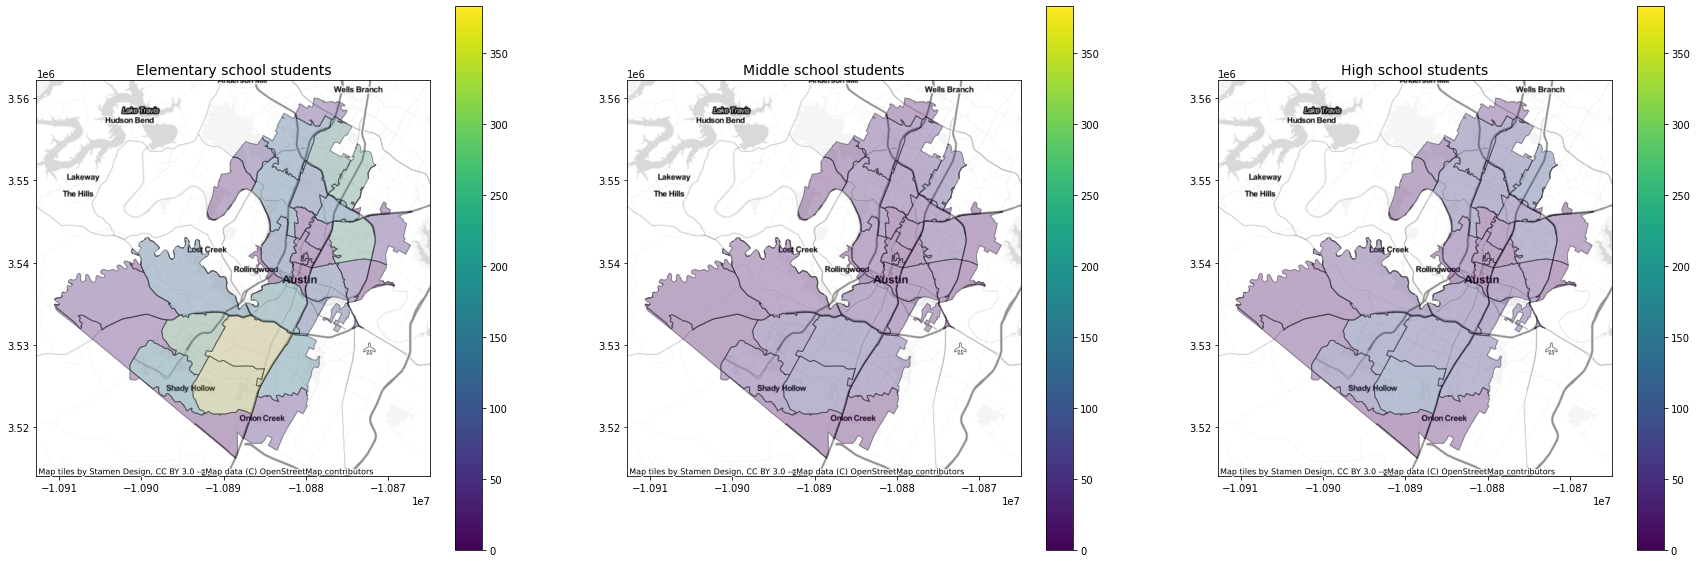

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
#divider = make_axes_locatable(ax)
#ax.set_axis_off()
sims_q50_shape_example_[sims_q50_shape_example_['age'] == '05-10'].to_crs('EPSG:3857').plot(
    'value', ax=ax[0], legend=True, edgecolor='black', lw=1, alpha=0.1,
    #legend_kwds={'bbox_to_anchor': (1.75, 1), 'fontsize': 14}
)
sims_q50_shape_example_[sims_q50_shape_example_['age'] == '11-13'].to_crs('EPSG:3857').plot(
    'value', ax=ax[1], legend=True, edgecolor='black', lw=1, alpha=0.1,
    #legend_kwds={'bbox_to_anchor': (1.75, 1), 'fontsize': 14}
)
sims_q50_shape_example_[sims_q50_shape_example_['age'] == '14-17'].to_crs('EPSG:3857').plot(
    'value', ax=ax[2], legend=True, edgecolor='black', lw=1, alpha=0.1,
    #legend_kwds={'bbox_to_anchor': (1.75, 1), 'fontsize': 14}
)
ax[0].set_title('Elementary school students', fontsize=14)
ax[1].set_title('Middle school students', fontsize=14)
ax[2].set_title('High school students', fontsize=14)
cx.add_basemap(ax[0], source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[1], source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[2], source=cx.providers.Stamen.TonerLite)

# STOP HERE

In [76]:
import plotly.graph_objects as go
from ipywidgets import widgets

In [78]:
map_widget_options = {
    'vertex': sims_q50_shape['vertex'].unique(),
    'age': sims_q50_shape['age'].unique(),
    'risk': sims_q50_shape['risk'].unique()
}
map_widget_dict = {}
for key, value_ in map_widget_options.items():
    widget = widgets.Dropdown(
        description=str(key),
        value=value_[0],
        options=value_
    )
    map_widget_dict[key] = widget

In [ ]:
def choropleth_map(summary_ds, shape, map_widget_options, map_widget_dict):

    # default selections
    defaults = get_summary_defaults(summary_xr)
    selection = summary_xr.sel(defaults).to_dataframe().reset_index()
    d1 = summary_df[summary_df['date'] == max(dates)]

    # https://chart-studio.plotly.com/~empet/15243/animating-traces-in-subplotsbr/#/
    fig = make_subplots(
        rows=1, cols=1,
        specs=[[{"type": "mapbox"}]],
    )
    fig.add_trace(
        go.Scattermapbox(
            lat=[d1['lat']],
            lon=[d1['lon']],
            mode='markers',
            marker=dict(
                size=25,  # d1['marker_size'],
                color=d1['burden_per_10k'],
                colorbar=dict(title='', x=0.45),
                colorscale="Viridis",
                cmax=max(d1['burden_per_10k']),
                cmin=0
            ),
            customdata=d1[['vertex', 'burden_per_10k_str']].to_numpy(),
            hovertemplate=hovertemplate_left
        ),
        row=1,
        col=1
    )

    # for some reason I don't fully understand, we need to do this twice...
    fig.add_trace(
        go.Scatter(
            x=agg_slice['date'],
            y=agg_slice['burden_per_10k'],
            mode='lines',
            line=dict(width=2, color='gray', dash='dot'),
            hoverinfo='none'
        ), row=1, col=2
    )

    fig.add_trace(
        go.Scatter(
            x=agg_slice['date'],
            y=agg_slice['burden_per_10k'],
            mode='lines',
            line=dict(width=2, color='gray', dash='dot'),
            hoverinfo='none'
        ), row=1, col=2
    )

    # update with successive dates
    fig.update_layout(
        mapbox=dict(
            accesstoken=token,
            bearing=0,
            center=dict(lat=30.3,
                        lon=-97.7),
            pitch=0,
            zoom=8.5,
            style='light'
        )
    )

    frames = [
        go.Frame(
            data=[
                go.Scattermapbox(
                    lat=dataslice[dataslice['date'] == dates[k]]['lat'],
                    lon=dataslice[dataslice['date'] == dates[k]]['lon'],
                    marker=dict(
                        size=dataslice[dataslice['date'] == dates[k]]['marker_size'],  # 25
                        color=dataslice[dataslice['date'] == dates[k]]['burden_per_10k'],
                        colorbar=dict(title='', x=0.45),
                        colorscale="Viridis",
                        cmax=max(dataslice['burden_per_10k']),
                        cmin=min(dataslice['burden_per_10k'])
                    ),
                    customdata=dataslice[dataslice['date'] == dates[k]][['vertex', 'burden_per_10k_str']].to_numpy(),
                    hovertemplate=hovertemplate_left
                ),
                go.Scatter(
                    x=agg_slice['date'],
                    y=agg_slice['burden_per_10k'],
                    mode='lines',
                    line=dict(width=2, color='gray')
                ),
                go.Scatter(
                    x=[dates[k]],
                    y=[sum(agg_slice[agg_slice['date'] == dates[k]]['burden_per_10k'])],
                    mode='markers',
                    marker=dict(size=10, color='red'),
                    customdata=agg_slice[agg_slice['date'] == dates[k]][['date', 'burden_per_10k_str']].to_numpy(),
                    hovertemplate=hovertemplate_right
                )
            ],
            traces=[0, 1, 2],  # there are 2 subplots but three traces, we need to request the three traces here
            name=f'frame{k}') for k in range(len(dates))
    ]

    fig.update(frames=frames)

    sliders = [
        dict(
            steps=[
                dict(
                    method='animate',
                    args=[
                        [f'frame{k}'],
                        dict(mode='immediate', frame=dict(duration=len(dates), redraw=True),
                             transition=dict(duration=0))
                    ],
                    label=dates[k]
                ) for k in range(len(dates))
            ],
            transition=dict(duration=0),
            x=0.05,  # slider starting position
            y=-0.01,
            currentvalue=dict(
                font=dict(size=18),
                prefix='Date: ',
                visible=True,
                xanchor='left'),
            len=1.0)
    ]

    fig.update_xaxes(row=1, col=2, range=[min(dates), max(dates)])
    # fig.update_yaxes(row=1, col=2, range=[0, 142000])
    fig.update_layout(
        updatemenus=[
            dict(
                type='buttons',
                showactive=False,
                y=-0.05,
                x=0.01,
                xanchor='right',
                yanchor='top',
                pad=dict(t=0, r=10),
                buttons=[
                    dict(label='Play', method='animate',
                         args=[None,
                               dict(frame=dict(duration=500, redraw=True),
                                    transition=dict(duration=100),
                                    fromcurrent=True,
                                    mode='immediate')
                               ]
                         ),
                    dict(label='Pause', method='animate',
                         args=[
                             [None],  # None must be in brackets or the pause button does not work
                             dict(frame=dict(duration=0, redraw=False),
                                  mode='immediate',
                                  transition=dict(duration=0))
                         ]
                         )
                ]
            )
        ],
        template='plotly_white',
        font=dict(size=18),
        showlegend=False,
        sliders=sliders)
    fig.update_annotations(font_size=20)

    return fig
    # define data traces
    upper_trace = go.Scatter(
        x=selection['step'],
        y=selection['upper'],
        fill=None,
        mode='lines',
        line_color='rgba(255,255,255,0.2)',
        showlegend=False,
    )

    lower_trace = go.Scatter(
        x=selection['step'],
        y=selection['lower'],
        fill='tonexty',
        mode='lines',
        fillcolor='rgba(189,0,38,0.2)',
        line_color='rgba(255,255,255,0)',
        showlegend=False,
    )

    median_trace = go.Scatter(
        x=selection['step'],
        y=selection['median'],
        line_color='rgb(255,255,255)',
        name=None,
        showlegend=False,
    )

    # build widgets
    widget_dict = build_widgets(data_xr=summary_xr, defaults=defaults)

    def _response(change):
        selection = summary_xr.sel({key: _value.value for key, _value in widget_dict.items()}).to_dataframe().reset_index()

        with g.batch_update():
            g.data[0].y = selection['upper']
            g.data[1].y = selection['lower']
            g.data[2].y = selection['median']

    for key, val in widget_dict.items():
        val.observe(_response, names="value")

    g = go.FigureWidget(
        data=[upper_trace, lower_trace, median_trace],
        layout=go.Layout(
            plot_bgcolor='#fff',
            yaxis_title='N',
            font=dict(size=18)
        )
    )

    container1 = widgets.HBox(list(widget_dict.values()))
    return widgets.VBox([container1, g])

In [71]:
sims_q50_shape_ds = sims_q50_shape.set_index(['age', 'risk', 'step', 'compt']).to_xarray()

ValueError: cannot convert a DataFrame with a non-unique MultiIndex into xarray

In [ ]:
sims_q50_shape

## Results

In [2]:
import xarray as xr

In [3]:
# INFO:root:Initializing epidemic in vertex ['78705'], age group ['20-49'], risk group ['high']
#output = xr.open_zarr('/Users/kpierce/episimlab/examples/test_granular_agm_2.zarr/')

# INFO:root:Initializing epidemic in vertex ['78653'], age group ['5-19'], risk group ['high']
output = xr.open_zarr('/Users/kpierce/episimlab/examples/test_granular_agm_3.zarr/')

In [15]:
output

<xarray.Dataset>
Dimensions:                        (age: 5, compt: 9, step: 123, vertex: 54, risk: 2, value: 3)
Coordinates:
  * age                            (age) object '0-4' '20-49' ... '50-64' '65+'
  * compt                          (compt) object 'S' 'E' 'Pa' ... 'Ih' 'R' 'D'
  * risk                           (risk) object 'low' 'high'
  * step                           (step) datetime64[ns] 2020-02-29 ... 2020-...
  * vertex                         (vertex) object '78610' '78612' ... '78759'
Dimensions without coordinates: value
Data variables: (12/17)
    compt_model__state             (step, vertex, compt, age, risk) float64 dask.array<chunksize=(62, 27, 5, 3, 2), meta=np.ndarray>
    rate_E2Pa__tau                 float64 ...
    rate_E2Py__tau                 float64 ...
    rate_Iy2Ih__eta                float64 ...
    rate_S2E__beta                 float64 ...
    setup_contacts__contacts_fp    <U41 ...
    ...                             ...
    setup_seed__seed_entropy       int64 ...
    setup_sigma__tri_exposed_para  (value) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    setup_state__census_fp         <U46 ...
    setup_sto__sto_toggle          int64 ...
    setup_travel__dask_chunks      float64 ...
    setup_travel__travel_pat_fp    <U93 ...

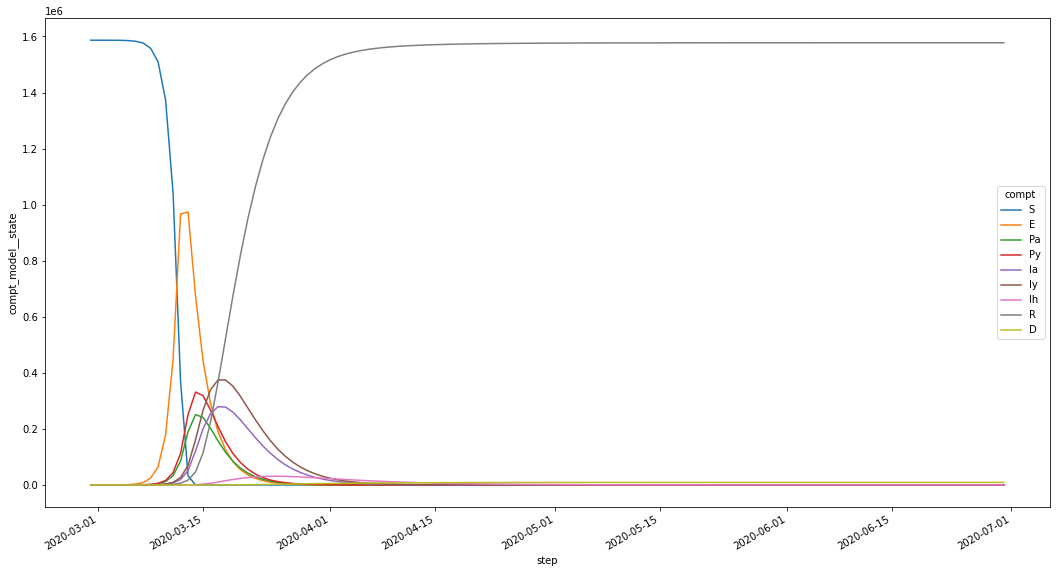

In [5]:
epidemic = output['compt_model__state'].sum(['age', 'risk', 'vertex']).plot.line(x='step', aspect=2, size=9)

In [6]:
results = output['compt_model__state'].to_dataframe().reset_index()
results.head()

,step,vertex,compt,age,risk,compt_model__state
0,2020-02-29,78610,S,0-4,low,2503.321951
1,2020-02-29,78610,S,0-4,high,344.678049
2,2020-02-29,78610,S,20-49,low,11468.011287
3,2020-02-29,78610,S,20-49,high,5299.988713
4,2020-02-29,78610,S,5-19,low,7226.602846


In [7]:
epi_results = results.groupby(['step', 'compt'])['compt_model__state'].sum()

In [8]:
epi_results.head()

step        compt
2020-02-29  D        0.0
            E        0.0
            Ia       1.0
            Ih       0.0
            Iy       0.0
Name: compt_model__state, dtype: float64

In [9]:
import pandas as pd
import datetime

In [10]:
results['step'] = pd.to_datetime(results['step'])

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
Ih = output['compt_model__state'].sel(dict(compt='Ih')).to_dataframe().reset_index()
Ih = Ih.rename(columns={'compt_model__state': 'hospital census'})
Ih['age'] = Ih['age'].astype("category")

Ih['age'].cat.categories = ['0-4', '5-19', '20-49', '50-64', '65+']

In [13]:
Ih.head()

,step,vertex,age,risk,compt,hospital census
0,2020-02-29,78610,0-4,low,Ih,0.0
1,2020-02-29,78610,0-4,high,Ih,0.0
2,2020-02-29,78610,5-19,low,Ih,0.0
3,2020-02-29,78610,5-19,high,Ih,0.0
4,2020-02-29,78610,20-49,low,Ih,0.0


/var/folders/hn/w8yttt8x7k5141wgqdcfv7fh0000gr/T/ipykernel_52035/594104760.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)


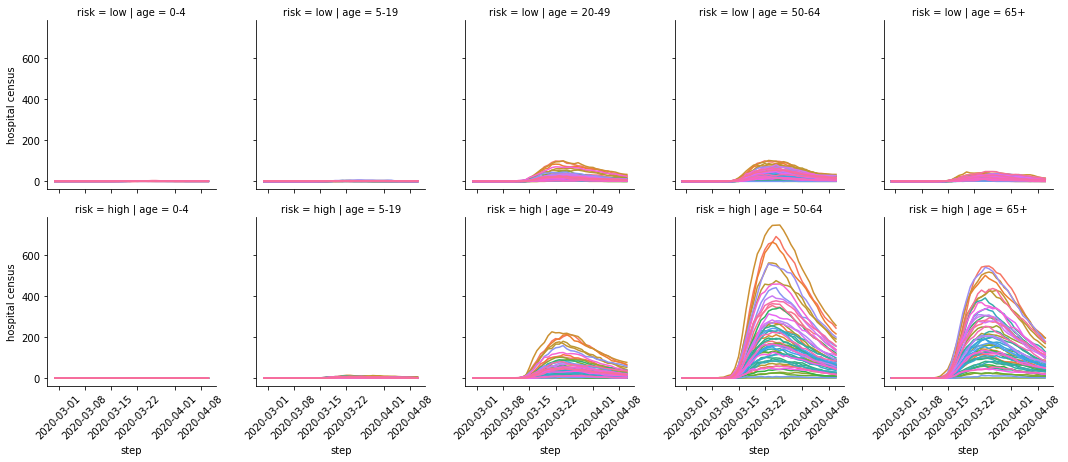

In [14]:
g = sns.FacetGrid(Ih[Ih['step'] < '2020-04-11'], col='age', row='risk', hue='vertex')
g.map(plt.plot, 'step', 'hospital census')
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

In [103]:
max(results['compt_model__state'])

29744.34757879284

In [104]:
import geopandas as gpd

atx_zcta = gpd.read_file('/Users/kpierce/COVID19/SchoolsGeography/atx_zip_code_shapefile/geo_export_9468462d-a639-46c5-a2e3-8c235db68411.shp')
atx_zcta['geoid10'] = [str(i) for i in atx_zcta['geoid10']]
atx_zcta = atx_zcta.rename(columns={'geoid10': 'vertex'})

In [105]:
atx_zcta.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [106]:
atx_zcta.head()

,affgeoid10,aland10,awater10,vertex,zcta5ce10,geometry
0,8600000US78612,243022885.0,1463994.0,78612,78612,"MULTIPOLYGON (((-97.52751 30.09283, -97.52721 ..."
1,8600000US78653,271051043.0,1296973.0,78653,78653,"POLYGON ((-97.63882 30.35289, -97.63077 30.360..."
2,8600000US78757,12732626.0,0.0,78757,78757,"POLYGON ((-97.75501 30.33623, -97.74342 30.361..."
3,8600000US78721,9588238.0,47149.0,78721,78721,"POLYGON ((-97.70142 30.28139, -97.70171 30.282..."
4,8600000US78745,34597868.0,0.0,78745,78745,"POLYGON ((-97.84494 30.20041, -97.83965 30.199..."


# 1. Set file paths for contact partitioning data

The contact partitioning process uses the travel and per capita contact rate data to calculate probability of contact between different age groups and different ZCTAs (assuming contacts are constant across risk groups).

These files are loaded directly into episimlab and processing happens behind the scenes.

In [2]:
travel_path = '/Users/kpierce/COVID19/safegraph_mobility/2020_travel_age_risk_for_contact_partitioning_agm_2022_demo_first_wave.csv'
polymod_path = '/Users/kpierce/episimlab/data/polymod_contacts.csv'

# 2. Load census data

Total population for each ZCTA, age and risk group is needed to set the initial susceptible populations. 

In [3]:
import pandas as pd

In [85]:
census = pd.read_csv(
    '/Users/kpierce/epimodels/sandbox-scripts/tx_zcta_high_risk_long.csv',
    dtype={'GEOID': str, 'banana': bool}
)

In [86]:
assert 'banana' in census.columns

AssertionError: 

In [5]:
census.head()

,Unnamed: 0,GEOID,age_bin,risk,estimate
0,0,75001,0-4,high,87.140716
1,1,75001,20-49,high,2546.867010
2,2,75001,5-19,high,282.514614
3,3,75001,50-64,high,848.093682
4,4,75001,65+,high,574.459288


# 3. Set the model initial state

The partition_v1 model which we will used is based on the Episimlab class [`ComptModel`](https://github.com/UT-Covid/episimlab/blob/3ead2e8f0934094a829004d61a4314ed88e5c217/episimlab/compt_model.py#L12). This class defines the model state as having the following dimensions:

- vertex
- compt (short for compartment)
- age
- risk

(Extensions of the model state to include other axes can be done by subclassing `ComptModel` and defining different axes.)

In [6]:
import xsimlab as xs
import xarray as xr

In [7]:
census = census.drop('Unnamed: 0', axis=1).rename(columns={'GEOID': 'vertex', 'age_bin': 'age'})

In [8]:
from copy import deepcopy

In [9]:
compt_fill = []
census['compt'] = 'S'
compt_fill.append(census)
for c in ['E', 'Pa', 'Py', 'Ia', 'Iy', 'Ih', 'R', 'D']:
    ccopy = deepcopy(census)
    ccopy['compt'] = c
    ccopy['estimate'] = 0.0 # remove the population
    compt_fill.append(ccopy)
full_census = pd.concat(compt_fill)

In [10]:
full_census.head()

,vertex,age,risk,estimate,compt
0,75001,0-4,high,87.140716,S
1,75001,20-49,high,2546.867010,S
2,75001,5-19,high,282.514614,S
3,75001,50-64,high,848.093682,S
4,75001,65+,high,574.459288,S


In [11]:
full_census = full_census.set_index(['vertex', 'age', 'risk', 'compt'])
census_xr = full_census.to_xarray()

In [93]:
full

<xarray.Dataset>
Dimensions:   (vertex: 1896, age: 5, risk: 2, compt: 9)
Coordinates:
  * vertex    (vertex) object '75001' '75002' '75006' ... '79936' '79938'
  * age       (age) object '0-4' '20-49' '5-19' '50-64' '65+'
  * risk      (risk) object 'high' 'low'
  * compt     (compt) object 'D' 'E' 'Ia' 'Ih' 'Iy' 'Pa' 'Py' 'R' 'S'
Data variables:
    estimate  (vertex, age, risk, compt) float64 0.0 0.0 0.0 ... 0.0 1.249e+03

In [12]:
from episimlab.models import PartitionFromTravel

In [13]:
@xs.process
class SetupStateAustin:
    """Initialize state matrix"""
    _coords = xs.group_dict('coords')
    state = xs.global_ref('state', intent='out')

    def initialize(self):
        self.state = census_xr
        self.state.loc[dict(compt='Pa', vertex='78712', age='20-49', risk='low')] = 1

    @property
    def dims(self):
        return get_var_dims(ComptModel, 'state')

    @property
    def coords(self):
        return group_dict_by_var(self._coords)

In [14]:
model = PartitionFromTravel()

We can inspect all the default settings in the model:

In [15]:
model.RUNNER_DEFAULTS

{'clocks': {'step': DatetimeIndex(['2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14',
                 '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18',
                 '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
                 '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
                 '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30',
                 '2020-03-31', '2020-04-01'],
                dtype='datetime64[ns]', freq='24H')},
 'input_vars': {'setup_sto__sto_toggle': 0,
  'setup_seed__seed_entropy': 12345,
  'rate_S2E__beta': 0.35,
  'rate_Iy2Ih__eta': 0.169492,
  'rate_E2Py__tau': 0.57,
  'rate_E2Pa__tau': 0.57,
  'setup_rho_Ia__tri_Pa2Ia': 2.3,
  'setup_rho_Iy__tri_Py2Iy': 2.3,
  'setup_sigma__tri_exposed_para': [1.9, 2.9, 3.9],
  'setup_gamma_Ih__tri_Ih2R': [9.4, 10.7, 12.8],
  'setup_gamma_Ia__tri_Iy2R_para': [3.0, 4.0, 5.0],
  'setup_mu__tri_Ih2D': [5.2, 8.1, 10.1],
  'travel_pat_fp': './tests/data/travel_pat0.csv',
  'contacts_f

In [16]:
austin_model = model.update_processes({
    'setup_state': SetupStateAustin,
})

In [17]:
austin_model.setup_state

<SetupStateAustin 'setup_state' (xsimlab process)>
Variables:
    _coords     [in] <--- group 'coords'
    state      [out] ---> compt_model.state
Simulation stages:
    initialize

In [18]:
austin_model.setup_state.initialize()

In [19]:
austin_model.state

{('compt_model',
  'state'): <xarray.Dataset>
 Dimensions:   (vertex: 1896, age: 5, risk: 2, compt: 9)
 Coordinates:
   * vertex    (vertex) object '75001' '75002' '75006' ... '79936' '79938'
   * age       (age) object '0-4' '20-49' '5-19' '50-64' '65+'
   * risk      (risk) object 'high' 'low'
   * compt     (compt) object 'D' 'E' 'Ia' 'Ih' 'Iy' 'Pa' 'Py' 'R' 'S'
 Data variables:
     estimate  (vertex, age, risk, compt) float64 0.0 0.0 0.0 ... 0.0 1.249e+03}

# 4. Configure the travel and contact inputs and simulation dates

In [20]:
import datetime

In [21]:
from episimlab.partition.travel_pat import TravelPatFromCSV

In [22]:
austin_model = austin_model.update_processes({
    'setup_travel': TravelPatFromCSV,
})

In [23]:
austin_model.setup_travel

<TravelPatFromCSV 'setup_travel' (xsimlab process)>
Variables:
    travel_pat_fp     [in] path to a CSV file containing travel pat...
    travel_pat       [out] ---> partition.travel_pat
    dask_chunks       [in] number of chunks in which to divide the ...
Simulation stages:
    initialize
    run_step

In [32]:
austin_model.PROCESSES

{'compt_model': episimlab.compt_model.ComptModel,
 'setup_sto': episimlab.setup.sto.SetupStochasticFromToggle,
 'setup_seed': episimlab.setup.seed.SeedGenerator,
 'setup_compt_graph': episimlab.models.partition_v1.SetupComptGraph,
 'int_per_day': episimlab.utils.datetime.IntPerDay,
 'setup_coords': episimlab.models.partition_v1.SetupCoords,
 'setup_state': episimlab.models.partition_v1.SetupState,
 'setup_travel': episimlab.partition.travel_pat.TravelPatRepeatDaily,
 'setup_contacts': episimlab.partition.contacts.ContactsFromCSV,
 'partition': episimlab.partition.partition.Partition,
 'setup_omega': episimlab.models.partition_v1.SetupOmega,
 'setup_pi': episimlab.models.partition_v1.SetupPiDefault,
 'setup_nu': episimlab.models.partition_v1.SetupNuDefault,
 'setup_mu': episimlab.setup.greek.mu.SetupStaticMuIh2D,
 'setup_gamma_Ih': episimlab.setup.greek.gamma.SetupGammaIh,
 'setup_gamma_Ia': episimlab.setup.greek.gamma.SetupGammaIa,
 'setup_gamma_Iy': episimlab.setup.greek.gamma.SetupGa

In [24]:
austin_model.RUNNER_DEFAULTS['input_vars']['travel_pat_fp'] = travel_path
austin_model.RUNNER_DEFAULTS['input_vars']['contacts_fp'] = polymod_path
austin_model.RUNNER_DEFAULTS['clocks'] = {
    'step': pd.date_range(start=datetime.datetime(2020, 2, 29), end=datetime.datetime(2020, 6, 30), freq='24H')
}

In [25]:
model.RUNNER_DEFAULTS

{'clocks': {'step': DatetimeIndex(['2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03',
                 '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07',
                 '2020-03-08', '2020-03-09',
                 ...
                 '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
                 '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
                 '2020-06-29', '2020-06-30'],
                dtype='datetime64[ns]', length=123, freq='24H')},
 'input_vars': {'setup_sto__sto_toggle': 0,
  'setup_seed__seed_entropy': 12345,
  'rate_S2E__beta': 0.35,
  'rate_Iy2Ih__eta': 0.169492,
  'rate_E2Py__tau': 0.57,
  'rate_E2Pa__tau': 0.57,
  'setup_rho_Ia__tri_Pa2Ia': 2.3,
  'setup_rho_Iy__tri_Py2Iy': 2.3,
  'setup_sigma__tri_exposed_para': [1.9, 2.9, 3.9],
  'setup_gamma_Ih__tri_Ih2R': [9.4, 10.7, 12.8],
  'setup_gamma_Ia__tri_Iy2R_para': [3.0, 4.0, 5.0],
  'setup_mu__tri_Ih2D': [5.2, 8.1, 10.1],
  'travel_pat_fp': '/Users/kpierce/COVID19/safegraph_mobili

# 5. Finalize imports and run model

In [26]:
from episimlab.models import ExampleSIR, EpiModel
from episimlab.models.example_sir import SetupPhi
from episimlab.models.partition_v1 import *
from episimlab.compt_model import ComptModel
from episimlab.foi import BaseFOI
from episimlab.utils import get_var_dims, group_dict_by_var, visualize_compt_graph, coerce_to_da, fix_coord_dtypes, IntPerDay
from episimlab.setup.sto import SetupStochasticFromToggle
from episimlab.setup.seed import SeedGenerator
import networkx as nx

In [27]:
output = austin_model.run()

INFO:root:No path to config (`config_fp`) was specified. Using model defaults.
INFO:root:The date in Partition.get_travel_df is ['2020-02-29T00:00:00.000000000']
ERROR:root:17.7% values in travel DataFrame are null
INFO:root:The date in Partition.get_travel_df is ['2020-02-29T00:00:00.000000000']
ERROR:root:17.7% values in travel DataFrame are null


ValueError: Value of type <class 'xarray.core.dataset.Dataset'> is less than 0: <xarray.Dataset>
Dimensions:   (vertex: 0, age: 2, risk: 2, compt: 4)
Coordinates:
  * vertex    (vertex) object 
  * age       (age) object '50-64' '65+'
  * risk      (risk) object 'high' 'low'
  * compt     (compt) <U2 'Ia' 'Iy' 'Pa' 'Py'
Data variables:
    estimate  (age, vertex, compt, risk) float64 

In [ ]:
census_xr.sel(dict(vertex=census_xr.vertex[0]))